In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from copy import deepcopy

from scripts.utils import drop_similar, update_occupations, filter_rare_occupations, filter_outlier_wikidata

from fuzzywuzzy import fuzz


from os.path import join
import json

DATA_PATH = 'data'

with open(join(DATA_PATH, 'countries_vocab.json'), 'r', encoding="utf-8") as f:
    countries_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    coun_num = len(set(countries_dict.values()))
    print(f"Number of countries: {coun_num}")
    
with open(join(DATA_PATH, 'occupations_vocab.json'), 'r', encoding="utf-8") as f:
    occupations_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    occ_num = len(set(occupations_dict.values()))
    print(f"Number of occupations: {occ_num}")
df = pd.read_json(join(DATA_PATH, 'union.json'), lines=True)
df["s"] = df["s"].apply(lambda x: x.lower())
del df["id"]

Number of countries: 180
Number of occupations: 1249


> First of all we will drop the persons, which was not found in Wikidata. This persons should have a special attention, especially those, who have a big number of quotations. However for them we will need to manually join the information about a certain person, since their QID was not found in the current version Wikidata.

In [5]:
df = df[~df.apply(lambda x: not(x["gender"] or x["birth"] or x["occupation_ids"] or x["citizenship_id"]), axis=1)]

> Next we will get rid of quotes, which are not related to `bitcoin` and `crypto`. For instance quates, containing subphrases like: `little bit`, `bitching`

In [6]:
 df = df[df["q"].apply(lambda x: 
                       (" a bit " not in x) and 
                       (" little bit " not in x) and 
                       (" every bit confident " not in x) and 
                       ("bitching" not in x)
                      )
        ]

> Lets then preprocess the list of occupations we have. As can be observerd, there are multiple occupations containing similar words: e.g. `music teacher`, `biology teacher`, `school teacher`

In [7]:
from collections import Counter

occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:15]

[('player', 50),
 ('artist', 38),
 ('designer', 22),
 ('manager', 22),
 ('coach', 22),
 ('director', 21),
 ('of', 18),
 ('engineer', 17),
 ('game', 15),
 ('video', 14),
 ('writer', 14),
 ('scientist', 13),
 ('officer', 13),
 ('actor', 13),
 ('historian', 13)]

> We will join all the profession containing `artist`, `player`, `video game`. Moreover we will replace `chief executive officer` with `executive director` to distingfish them from `police officer`

In [8]:
occupations_dict = update_occupations(occupations_dict)
occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:20]

[('sport', 196),
 ('artist', 40),
 ('manager', 20),
 ('designer', 18),
 ('director', 17),
 ('engineer', 17),
 ('of', 17),
 ('video-game', 16),
 ('actor', 15),
 ('scientist', 13),
 ('writer', 13),
 ('historian', 13),
 ('activist', 12),
 ('political', 12),
 ('music', 11),
 ('critic', 10),
 ('art', 9),
 ('officer', 9),
 ('teacher', 9),
 ('journalist', 9)]

In [9]:
df.head()

,q,d,s,o,gender,birth,occupation_ids,citizenship_id
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30]
7,i saw steppenwolf do the cryptogram ive seen w...,2008-10-24 20:45:16,raúl esparza,1,[male],[+1970-10-24T00:00:00Z],"[[Q177220, Q2259451, Q10800557, Q10798782, Q33...",[Q30]
8,while we need to identify and prohibit conduct...,2008-09-08 15:59:54,thomas barnett,1,"[male, male, male]","[+1962-01-01T00:00:00Z, +1799-01-01T00:00:00Z,...","[[Q16947320, Q1238570, Q36180, Q8246794], None...","[Q30, None, Q30]"
9,this is the third time in as many years that p...,2008-09-02 08:19:53,albert owen,2,[male],[+1959-08-10T00:00:00Z],[[Q82955]],[Q145]
13,this can impact on the quality of the water we...,2008-11-24 18:32:36,peter perry,2,[male],[+1936-04-11T00:00:00Z],[[Q937857]],[Q145]


>Columns:  
q = "quote"  
d = "date"  
s = "speaker"  
o = "occurancies"  
gender = gender of the speakers  
birth = birth dates of the speakers  
occupation_ids = wikidata ids of the speakers' occupancies  
citizenship_id = wikidata ids of the speakers' citizenship


> Then we filter occupations, which occured only single time in the entire dataset, for instance, `ufc lightweight fighter`.

In [10]:
occ_freq = defaultdict(int)
for occ_ids in df["occupation_ids"].values:
    if occ_ids is not None:
        for occs in occ_ids:
            if occs is not None:
                for o in occs:
                    occ_freq[o] += 1
                
df = df.apply(lambda x: filter_rare_occupations(x, occ_freq), axis=1)

In [11]:
occ_set = set()
for occ_lsts in df["occupation_ids"].values:
    if occ_lsts is not None:
        for lst in occ_lsts:
            if lst is not None:
                occ_set.update(lst)
print(f"Reduced number of occupations: {len(occ_set)}")

Reduced number of occupations: 891


> Next we will fiter Wikidata pages without `occupation` or `citizenship`. Also we will filter `genders` and `citizenship`, which does not match the `gender` and `citizenship` of majority

In [12]:
df = df.apply(lambda x: filter_outlier_wikidata(x), axis=1)
df = df[~df.apply(lambda x: not(x["gender"] or
                                x["birth"] or 
                                x["occupation_ids"] or
                                x["citizenship_id"]), axis=1)]
percent = (df["citizenship_id"].apply(len) > 1).sum() / len(df)

print(f"Percent of quotations in dataset, where more then one QID is joined {percent}")  

df["gender"] = df["gender"].apply(lambda x: x[0])
df["citizenship_id"] = df["citizenship_id"].apply(lambda x: x[0])

Percent of quotations in dataset, where more then one QID is joined 0.17980425173647654


> Next we will split the dates

In [13]:
df['publish_year'] = df['d'].apply(lambda x: x[:4])
df['publish_month'] = df['d'].apply(lambda x: x[5:7])

> The first plot we build to validate if everything is correct is `number of occurancies` w.r.t. `publish year` 

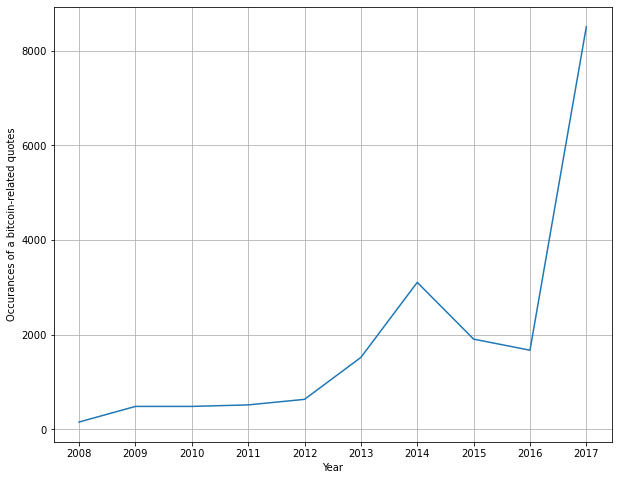

In [14]:
plt.figure(figsize=(10,8))
plt.plot(df.groupby('publish_year')['o'].count())
plt.xlabel("Year")
plt.ylabel("Occurances of a bitcoin-related quotes")
plt.grid()
plt.show()

> Seems like everything is okey, since the two main increases in popularity of bitcoin was indeed in `2014` and `2017`, according to the `Google trends`

> The most cited pearsons also seems reasonable

In [17]:
df.groupby(['s']).sum()['o'].sort_values(ascending=False).head(10)

s
jamie dimon             665
mark karpeles           626
thomas peterffy         589
craig wright            586
adrian lee              585
leah mcgrath goodman    504
charlie sheen           446
bobby lee               444
gavin andresen          437
tyler winklevoss        401
Name: o, dtype: int64

In [18]:
df.groupby(['s']).count()['o'].sort_values(ascending=False).head(10)

s
gavin andresen          167
jamie dimon             159
charlie lee             152
bobby lee               148
patrick byrne           145
roger ver               144
vitalik buterin         135
andreas antonopoulos    108
tyler winklevoss         96
mark karpeles            90
Name: o, dtype: int64

> Then we will reduce the number of occupations, since most of them are very simmilar. We will utilize `fuzzywuzzy` to find similar words. Then we will build a graph, where the vertices are the `occupations`, and edge between $o_i$ and $o_j$ exists if the similarity in terms of `fuzzywuzzy` metric is greater then a treshold.

In [19]:
import networkx
from networkx.algorithms.components.connected import connected_components
from fuzzywuzzy import fuzz
from collections import defaultdict, Counter

In [20]:
def to_graph(cliques):
    G = networkx.Graph()
    for cli in cliques:
        G.add_nodes_from(cli)
        G.add_edges_from(to_edges(cli))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

In [21]:
occupations_dict = drop_similar(occupations_dict)

In [22]:
len(set(occupations_dict.values()))

606

In [23]:
ids = set(sum([e for e in df["occupation_ids"].values.sum() if e is not None], []))
for i in ids:
    if i not in occupations_dict:
        del occupations_dict[i]

In [24]:
names1 = (df.groupby("s").sum() > 10).reset_index()
names1 = names1.loc[names1["o"], "s"]
names1 = set(names1.values)
names2 = (df.groupby("s").count() > 3).reset_index()
names2 = names2.loc[names2["o"], "s"]
names2 = set(names2.values)

names = names2.intersection(names1)

df = df[df["s"].apply(lambda x: x in names)]

In [26]:
def select_occupation(x):
    output = []
    
    for elem in x:
        if elem is not None:
            output += list(set(occupations_dict[e] for e in elem))
    output = list(set(output))
    
    if not output:
        return None
    else:
        if (output[0] == "sport") or (output[0] == "writer"):
            if len(output) > 1:
                return output[1]
            else:
                return output[0]
        else:
            return output[0]

In [31]:
df = df[df["birth"].apply(lambda x: len(x) < 2)]
df["occupation"] = df["occupation_ids"].apply(lambda x: select_occupation(x))

/var/folders/zr/9df_syx90yvdyhsrsgyjwknc0000gn/T/ipykernel_10392/2683811197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["occupation"] = df["occupation_ids"].apply(lambda x: select_occupation(x))


In [32]:
df_grouped = df.groupby(['publish_year', 'occupation'], as_index=False).sum()
df_grouped_top = (df_grouped
                  .sort_values(['publish_year','o'], ascending=False)
                  .groupby(['publish_year'], as_index=False)
                  .head(5))

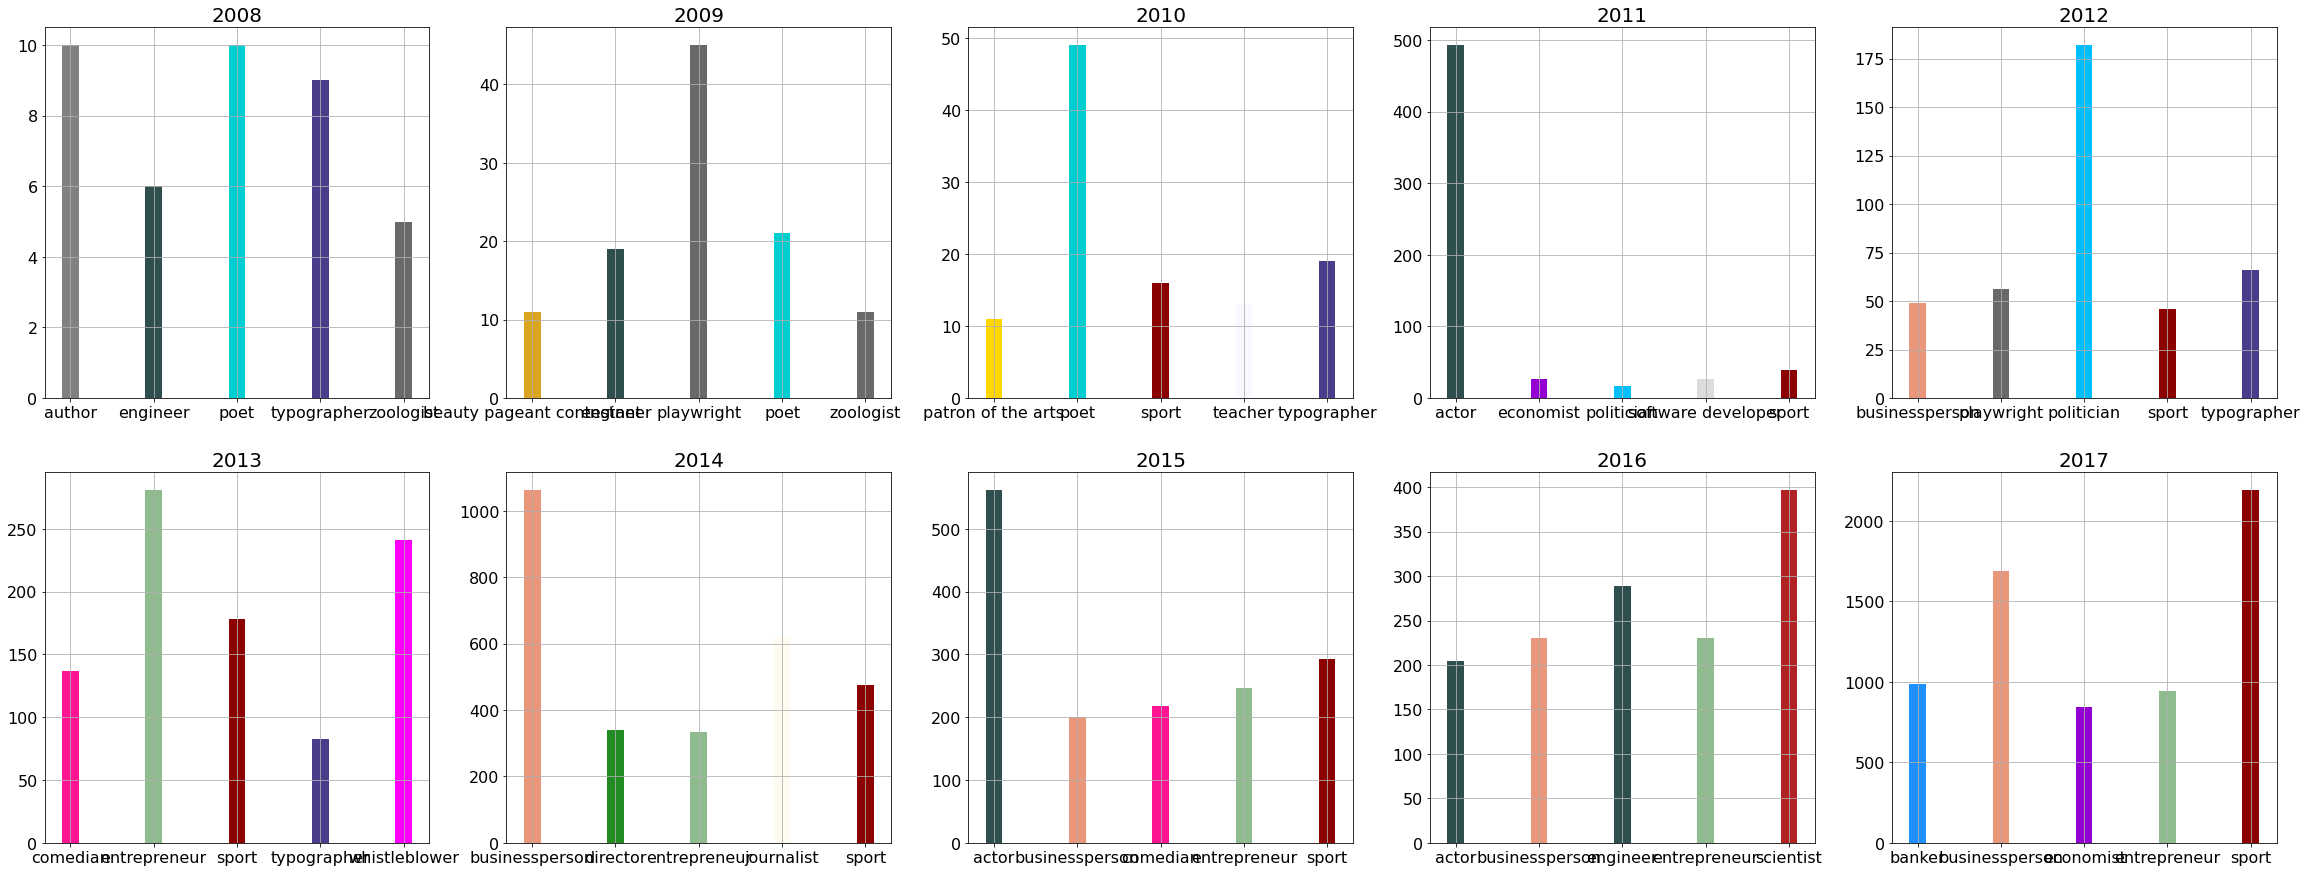

In [44]:
from matplotlib import colors as mcolors

group_colors = {}
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = list(colors.values())
unique_top_occupation_groups = [elem[0] for elem in Counter(df_grouped_top.occupation).most_common()]
for i, group_number in enumerate(unique_top_occupation_groups):
    group_colors[group_number] = colors[i + 40]

fig, axs = plt.subplots(2, 5, figsize=(40, 15))
step = [0, 1, 2, 3, 4]

years = np.unique(df_grouped_top.publish_year)
for i, year in enumerate(years):
    year_df = df_grouped_top[df_grouped_top.publish_year == year]
    year_occupations = np.unique(year_df.occupation)
    
    for group_n, group_ in enumerate(year_occupations):
        temp_group = year_df[year_df.occupation == group_]
        axs[i // 5][i % 5].bar(group_,
                               temp_group.o.values[0], 
                               color=group_colors[group_], 
                               alpha=1, 
                               width=0.2,
                               align='center')
    axs[i // 5][i % 5].set_title(year, fontsize=20)
    axs[i // 5][i % 5].grid()
    axs[i // 5][i % 5].tick_params(axis='both', which='major', labelsize=16)
plt.show()

> It seems like the distribution over is a little varied. As we can see, people with sport `occupation` speak up about `bitcoin` and `blockchain` rather more frequent, then other people. It is an interesting observation, since most of the quotes seems to be relevant to `bitcoin`, `blockchain`, and other buzz-words

---

Now we want to find when exactly did the "hype" around bitcoin and cryptocurrencies start.

We will find that by looking at what dates did we get the "noticeable" boosts of related phrases, such that the trend was preserved in the future

In [83]:
df.publish_year = df.publish_year.apply(int)

/opt/homebrew/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


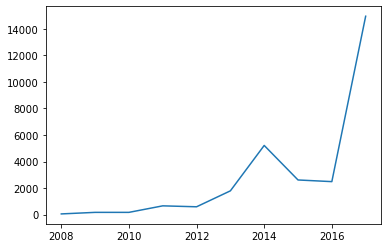

In [84]:
plt.plot(df.groupby('publish_year')['o'].sum())
plt.show()

Let's see the quote that spread the most each year 

In [85]:
for year in np.unique(df.publish_year.values):
    line = df[df.publish_year==year].sort_values('o', ascending=False).head(1)
    
    print(f'--{year}')
    print(f'Speaker: {line.s.values[0]}') 
    print(f'Count: {line.o.values[0]}')

--2008
Speaker: george orwell
Count: 6
--2009
Speaker: gore vidal
Count: 16
--2010
Speaker: president barack obama
Count: 24
--2011
Speaker: charlie sheen
Count: 170
--2012
Speaker: chris christie
Count: 106
--2013
Speaker: edward snowden
Count: 182
--2014
Speaker: mark karpeles
Count: 258
--2015
Speaker: adrian lee
Count: 128
--2016
Speaker: craig wright
Count: 51
--2017
Speaker: thomas peterffy
Count: 463


Let's see now the relative change of total quotes for the day, relative to the previous day

In [137]:
MIN_YEAR = 2009
MAX_YEAR = 2018
daily_occurence_sums = (df[(MIN_YEAR < df['publish_year']) &
                           (df['publish_year'] < MAX_YEAR)]
                        .groupby('d').sum().values[:, 0])
daily_occurence_sums

array([ 5,  4, 10, ...,  3,  1,  8])

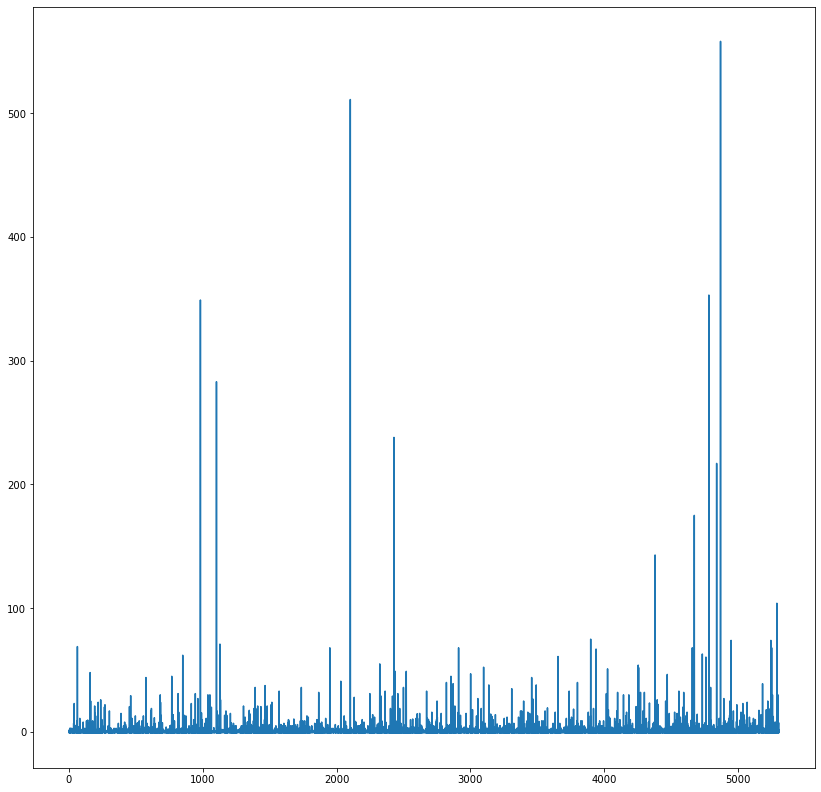

In [138]:
daily_occurence_t1 = np.roll(daily_occurence_sums, 1)  # t + 1

# take the proportion of the change (n(t) - n(t-1)) / n(t - 1)
daily_occurence_differences = ((daily_occurence_sums - daily_occurence_t1 ) / daily_occurence_t1)[1:]
plt.figure(figsize=(14, 14))
plt.plot(daily_occurence_differences)
plt.show()

Not much information can bee seen there, let's do an averaging with the window 

In [153]:
def moving_average(data, window=7, stride=1) :
    window_averages = []
    
    # just avoiding potentially weird inputs
    if stride < 1:
        stride = 1
        
    for i in range(len(data))[:-stride:stride]:
        window_first_day = i * window
        window_last_day =  window_first_day + window
#         print(window_first_day, window_last_day)
        window_averages.append(data[window_first_day: window_last_day].mean())
    
    return range(len(data))[:-stride:stride], window_averages

/var/folders/zr/9df_syx90yvdyhsrsgyjwknc0000gn/T/ipykernel_10392/4192452084.py:12: RuntimeWarning: Mean of empty slice.
  window_averages.append(data[window_first_day: window_last_day].mean())


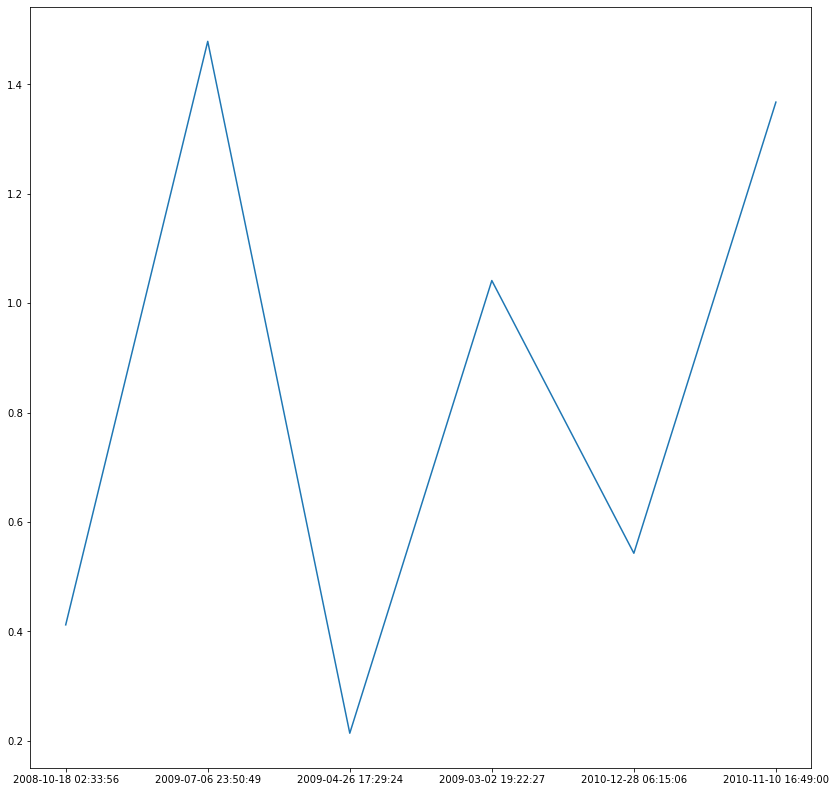

In [154]:
WINDOW_DAYS = 30

# window_first_day_numbers = [n for n in range(len(daily_occurence_differences))]
window_first_day_numbers, window_averaged_occurences = moving_average(daily_occurence_differences,
                                                                      window=WINDOW_DAYS,
                                                                      stride=WINDOW_DAYS)

window_first_day_dates = [df.d.values[i] for i in window_first_day_numbers]
plt.figure(figsize=(14, 14))
plt.plot(window_first_day_dates, window_averaged_occurences)
plt.show()

In [141]:
window_first_day_dates

['2008-10-18 02:33:56',
 '2009-07-06 23:50:49',
 '2009-04-26 17:29:24',
 '2009-03-02 19:22:27',
 '2010-12-28 06:15:06',
 '2010-11-10 16:49:00',
 '2011-06-17 08:16:10',
 '2011-03-01 21:55:00',
 '2011-03-11 11:33:11',
 '2011-04-04 16:05:00',
 '2012-08-01 07:31:25',
 '2012-01-17 22:13:45',
 '2012-02-10 14:17:57',
 '2012-06-07 16:05:16',
 '2012-10-03 13:50:06',
 '2012-12-17 11:30:00',
 '2013-11-21 20:59:51',
 '2013-12-05 16:09:39',
 '2013-02-26 23:31:55',
 '2013-11-12 20:34:00',
 '2013-12-18 15:15:22',
 '2013-11-22 16:27:01',
 '2013-11-07 09:20:45',
 '2013-12-05 12:59:00',
 '2013-05-14 13:10:27',
 '2013-05-21 09:31:03',
 '2013-11-18 03:00:00',
 '2013-04-17 04:32:21',
 '2013-06-14 15:27:00',
 '2013-12-05 14:19:00',
 '2013-12-05 22:20:14',
 '2013-11-18 09:53:22',
 '2013-11-22 11:31:00',
 '2013-06-14 19:18:01',
 '2013-07-12 21:51:35',
 '2013-01-22 14:18:06',
 '2013-11-27 15:10:00',
 '2013-07-25 01:48:40',
 '2014-09-03 20:35:13',
 '2014-03-28 06:17:16',
 '2014-03-10 18:36:37',
 '2014-04-22 19: